In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import medfilt
import pandas as pd
import json

from fcutils.plot.figure import set_figure_subplots_aspect, clean_axes
from fcutils.maths import derivative
from fcutils.plot.elements import plot_mean_and_error
from fcutils.plot.distributions import plot_kde
from fcutils.maths import rolling_mean

import sys
sys.path.append("/Users/federicoclaudi/Documents/Github/LocomotionControl")
# sys.path.append(r"C:\Users\Federico\Documents\GitHub\pysical_locomotion")


Define track class to map (x,y) -> s

In [3]:
# track_fp = "/Users/federicoclaudi/Documents/Github/LocomotionControl/thesis/chpt3/track.json"
track_fp = r"C:\Users\Federico\Documents\GitHub\pysical_locomotion\thesis\chpt3\track.json"
class Track:
    def __init__(self):
        # load track from json
        with open(track_fp, "r") as fin:
            track = json.load(fin)

        self.x = np.array(track["X"])
        self.y = np.array(track["Y"])
        self.theta = np.array(track["θ"])
        self._curv = np.array(track["curvature"])
        self.S = np.array(track["S"])
        self.width = np.array(track["width"])


    def get_at_sval(self, s):
        """
            Get the x,y,theta at a given s value
        """
        idx = np.argmin(np.abs(self.S - s))
        return self.x[idx], self.y[idx], self.theta[idx]

    def curvature(self, s):
        """
            Get the curvature at a given s value
        """
        idx = np.argmin(np.abs(self.S - s))
        return self._curv[idx]

    def w(self, s):
        """
            Return width at given s value
        """
        idx = np.argmin(np.abs(self.S - s))
        return self.width[idx]

    def s(self, x, y):
        """
            Get the s value of the track's closest point to (x,y)
        """
        # get closest point
        idx = np.argmin(np.sqrt((self.x - x) ** 2 + (self.y - y) ** 2))
        return self.S[idx]

track = Track()

KeyError: 'θ'

## Preamble

In [4]:
# Load trials
# fld = Path("/Users/federicoclaudi/Dropbox (UCL)/Rotation_vte/Locomotion/analysis/behavior/jl_trials_cache")
fld = Path(r"D:\Dropbox (UCL)\Rotation_vte\Locomotion\analysis\behavior\jl_trials_cache")

# load all json files in fld
all_files = [f for f in fld.glob('*.json')]

def isvalid(trial):
    if trial["duration"][0] > 9:
        return False

    if trial["s"][0] > 15:
        return False

    if trial["s"][-1] < 255:
        return False

    return True

def trim(trial):
    """
        Cut the trial to when the mouse starts running
    """
    sdot = np.diff(trial["s"])
    start = np.where(sdot >= .15)[0][0]
    stop = np.where(np.array(trial["s"]) > 259)[0]  
    if not len(stop):
        return None
    stop = stop[0]
    trial = {k: v[start:stop] for k, v in trial.items()}
    return trial



# load all_json to a list of dict
all_trials = [json.load(open(f)) for f in all_files]
trials = [t for t in all_trials if isvalid(t)]
trials = [trim(t) for t in trials]
trials = [t for t in trials if t is not None]

X, Y = np.hstack([t["x"] for t in trials]), np.hstack([t["y"] for t in trials]) 
speed = rolling_mean(np.hstack([t["speed"] for t in trials]), 21)
accel = derivative(speed) * 60 # convert to cm/s^2
angvel = rolling_mean(np.hstack([t["ω"] for t in trials]), 21)
angacc = derivative(angvel) * 60 # convert to deg/s^2

durations = np.hstack([t["duration"][0] for t in trials])

print(f"Kept {len(trials)} trials out of {len(all_trials)}")

KeyError: 'ω'

load "reverse" trials

In [ ]:
# random_frames = pd.read_json("/Users/federicoclaudi/Dropbox (UCL)/Rotation_vte/Locomotion/analysis/behavior/random_frames_tracking.json")
random_frames = pd.read_json(r"D:\Dropbox (UCL)\Rotation_vte\Locomotion\analysis\behavior\random_frames_tracking.json")
print(len(random_frames))
random_frames.head()

def bound_array(x, vmin, vmax, clip_0=False):
    x = x.copy()
    x[(x < vmin) | (x > vmax)] = np.nan
    if clip_0:
        x[(-5 < x) & (x < 5)] = np.nan
    return x


411763


In [ ]:
# make a function that adds a colorbar to a subplot
def add_colorbar(ax, im, cbar_label):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
    cbar.set_label(cbar_label)
    return cbar


def heatmap(ax, X, Y, Z, cmap, label, vmin=None, vmax=None):
    im = ax.hexbin(
        X, Y, Z, cmap=cmap, vmin=vmin, vmax=vmax, gridsize=(40, 60),
    )
    add_colorbar(ax, im, label)
    ax.axis("equal")
    ax.axis("off")

get average speed during random frames

In [ ]:
random_frames_speed = np.clip(
    random_frames["speed"].values, 0, 100
)
m = random_frames_speed.mean()
s = random_frames_speed.std()

print(f"Mean speed: {m:.2f} ± {s:.2f}")

Mean speed: 23.67 ± 16.97


do a *t test* to see if speed distributsions are different

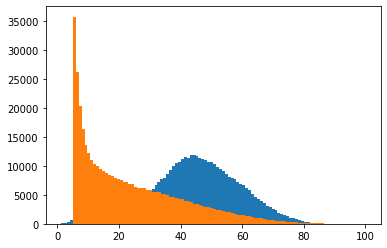

In [ ]:
plt.hist(speed, bins=100)
_ = plt.hist(random_frames_speed, bins=100)


In [ ]:
from scipy.stats import ttest_ind as ttest


s, p = ttest(
    speed, random_frames_speed
)
print(p)

0.0


## Plot
overall heatmaps and tracking plots

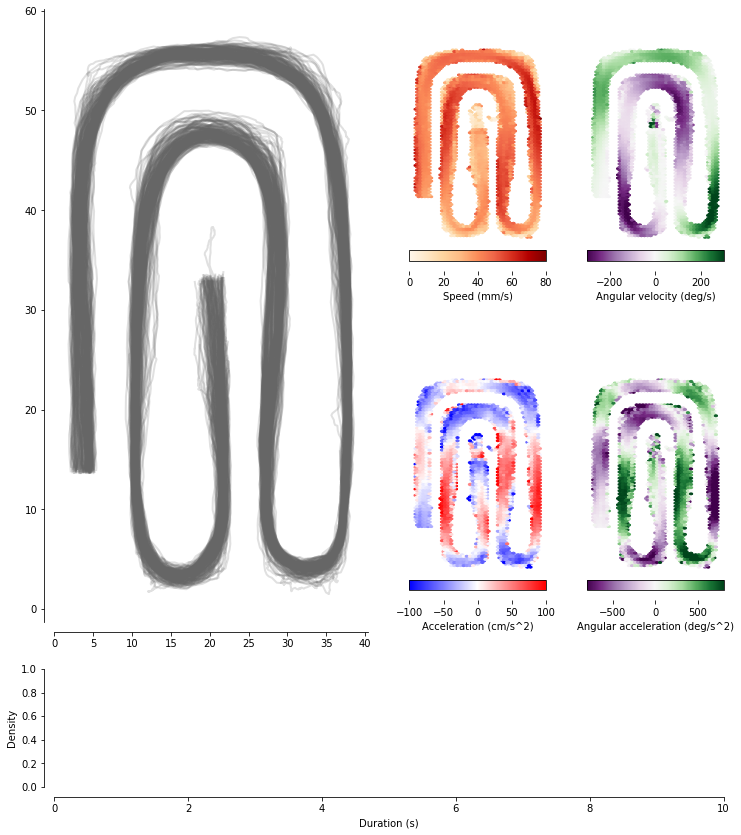

In [ ]:
fig = plt.figure(figsize=(12, 12))
axes = fig.subplot_mosaic(
"""
    AABC
    AABC
    AADE
    AADE
    FFFF
"""
)
set_figure_subplots_aspect(    left=0.125, right=0.9, bottom=0.06, top=0.96, wspace=0.3, hspace=0.4)


# load image
# img = plt.imread("/Users/federicoclaudi/Documents/Github/LocomotionControl/analysis/behavior/src/Hairpin.png")
# axes["A"].imshow(img, extent=[0, 40, 0, 60])

# plot trials traces
for i in range(200):
    # plot trial X, Y
    axes["A"].plot(trials[i]["x"], trials[i]["y"], color=[.4, .4, .4], lw=2, alpha=0.2)
# axes["A"].plot(trials[25]["x"], trials[25]["y"], color=salmon, lw=2, alpha=1)
# axes["A"].scatter(trials[25]["x"][0], trials[25]["y"][0], color="red", s=100, zorder=1000)
# axes["A"].scatter(trials[25]["x"][-1], trials[25]["y"][-1], color="black", s=100, zorder=1000)


# heatmaps
heatmap(axes["B"], X, Y, speed, "OrRd", "Speed (mm/s)", vmin=0, vmax=80)
heatmap(axes["C"], X, Y, angvel, "PRGn", "Angular velocity (deg/s)", vmin=-300, vmax=300)
heatmap(axes["D"], X, Y, accel, "bwr", "Acceleration (cm/s^2)", vmin=-100, vmax=100)
heatmap(axes["E"], X, Y, angacc, "PRGn", "Angular acceleration (deg/s^2)", vmin=-800, vmax=800)

# plot histogram of trials durations on ax F
# plot_kde(
#     axes["F"],
#     data=durations, color="black", kde_kwargs={"bw": 0.25},
# )
# axes["F"].hist(durations, bins=25, color="black", alpha=.1, density=True)

_ = axes["F"].set(xlabel="Duration (s)", ylabel="Density", xlim=[0, 10])
clean_axes(fig)

# save figure to svg
# fig.savefig("/Users/federicoclaudi/Dropbox (UCL)/Rotation_vte/Writings/THESIS/Chpt3/Plots/trials_heatmaps.svg", dpi=300)

KDEs of kinematics variables between trials and random frames

In [1]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()

# plot speeds KDE from trials data
plot_kde(
    axes[0],
    data=speed, color="black", kde_kwargs={"bw": 1},
)
plot_kde(
    axes[0],
    data=np.clip(random_frames["speed"].values, 0, 100), color="red", kde_kwargs={"bw": 1},
)

# # angular velocity
# plot_kde(
#     axes[1],
#     data=angvel, color="black", kde_kwargs={"bw": 5},
# )

# plot_kde(
#     axes[1],
#     data=bound_array(random_frames["thetadot"].values, -550, 550), color="red", kde_kwargs={"bw": 5},
# )


# # acceleration
# plot_kde(
#     axes[2],
#     data=bound_array(accel, -300, 300, clip_0=False), color="black", kde_kwargs={"bw": 1},
# )


# plot_kde(
#     axes[2],
#     data=bound_array(random_frames["acceleration"].values, -300, 300, clip_0=False), color="red", kde_kwargs={"bw": .1},
# )


# plot_kde(
#     axes[3],
#     data=bound_array(angacc, -800, 800, clip_0=False), color="black", kde_kwargs={"bw": 5},
# )
# plot_kde(
#     axes[3],
#     data=bound_array(random_frames["thetadotdot"], -800, 800, clip_0=False), color="red", kde_kwargs={"bw": 5},
# )

axes[0].set(xlabel="Speed (cm/s)", ylabel="Density",)
axes[1].set(xlabel="Angular velocity (deg/s)", ylabel="Density",)
axes[2].set(xlabel="Acceleration (cm/s^2)", ylabel="Density", ylim=[0.0, 0.05])
_ =  axes[3].set(xlabel="Angular acceleration (deg/s^2)", ylabel="Density",)

fig.savefig("/Users/federicoclaudi/Dropbox (UCL)/Rotation_vte/Writings/THESIS/Chpt3/Plots/trials_vs_random_frames_KDEs.svg", dpi=50)

NameError: name 'plt' is not defined

plot speed and angular velocity for trial/random frames as function of track progression

In [ ]:
# get track position
random_frames["s"] = [track.s(x, y) for x, y in zip(random_frames["x"], random_frames["y"])]

trials_frames = pd.DataFrame(dict(x=X, y=Y, speed=speed, acceleration=accel, thetadot=angvel, thetadotdot=angacc))
trials_frames["s"] = [track.s(x, y) for x, y in zip(trials_frames["x"], trials_frames["y"])]

NameError: name 'bin_x_by_y' is not defined

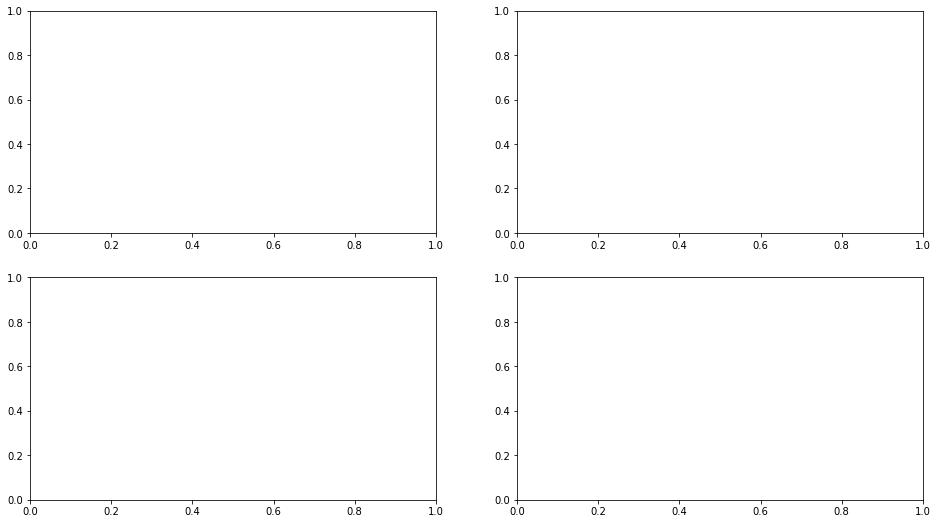

In [ ]:
fig, axes = plt.subplots(figsize=(16, 9), ncols=2, nrows=2)
axes = axes.flatten()

bins = np.linspace(0, 250, 100)

for var, ax in zip(("speed", "thetadot", "acceleration", "thetadotdot"), axes):
    _bins, mu_r, sigma_r, counts_r = bin_x_by_y(random_frames, var, "s", bins=bins)
    _bins, mu_t, sigma_t, counts_t = bin_x_by_y(trials_frames, var, "s", bins=bins)

    plot_mean_and_error(mu_r, sigma_r, ax=ax, color="black", label="Random", x=_bins)
    plot_mean_and_error(mu_t, sigma_t, ax=ax, color="red", label="Trials", x=_bins)
    ax.set(title=var)

fig.savefig("/Users/federicoclaudi/Dropbox (UCL)/Rotation_vte/Writings/THESIS/Chpt3/Plots/trials_vs_random_frames_kinematics.svg", dpi=50)

Heatmaps for random data

NameError: name 'random_frames' is not defined

<Figure size 1368x576 with 4 Axes>

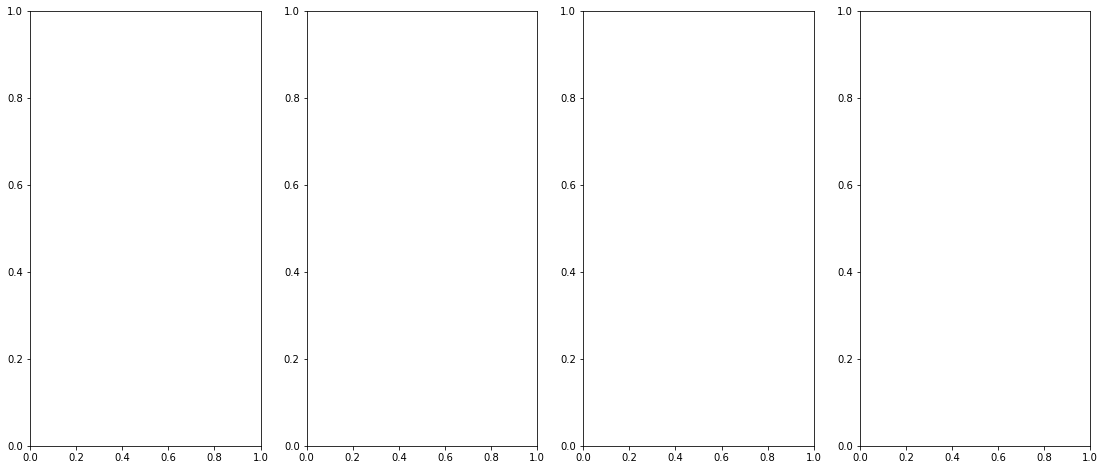

In [ ]:
f, axes = plt.subplots(1, 4, figsize=(19, 8))

_x, _y = random_frames["x"], random_frames["y"]
heatmap(axes[0], _x, _y, random_frames["speed"].values, "OrRd", "Speed (mm/s)", vmin=0, vmax=80)
heatmap(axes[1], _x, _y, random_frames["thetadot"], "PRGn", "Angular velocity (deg/s)", vmin=-100, vmax=100)


heatmap(axes[2], _x, _y, random_frames["acceleration"], "bwr", "Acceleration (cm/s^2)", vmin=-5, vmax=5)
heatmap(axes[3], _x, _y, random_frames["thetadotdot"], "PRGn", "Angular acceleration (deg/s^2)", vmin=-50, vmax=50)

f.savefig("/Users/federicoclaudi/Dropbox (UCL)/Rotation_vte/Writings/THESIS/Chpt3/Plots/trials_vs_random_frames_heatmaps.svg", dpi=50)

## GG Plots

Plot linear vs angular acceleration for trials data